# Click prediction challenge solution

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

First let's import the most essential libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In C:\Users\danii\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\danii\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\danii\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\danii\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\danii\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

## 1. Load the dataset

Now, let's import the data:

In [3]:
df = pd.read_csv('android_bids_us.csv')

In [4]:
df.head()

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0


Let's inspect the data in order to get sense of how much missing data we have, which features are present and what should be modified before applying next steps

In [5]:
df.shape

(3148828, 12)

There are over 3 millions samples, 11 features and 1 target variable. This should be enough for binary classification problem. However, the number of features might not be sufficient for training a powerful model. Thus, generating new features should be considered further. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148828 entries, 0 to 3148827
Data columns (total 12 columns):
bidid            object
utc_time         int64
app_id           object
user_state       object
user_isp         object
device_maker     object
device_model     object
device_osv       object
device_height    int64
device_width     int64
marketplace      object
click            int64
dtypes: int64(4), object(8)
memory usage: 288.3+ MB


Note, that most of the features are probably (object dtype) categorical.

Verify that the column containing the target variable is valid:

In [7]:
df['click'].describe()

count    3.148828e+06
mean     6.770741e-02
std      2.512432e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: click, dtype: float64

The range of the values is between 0 and 1 inclusively.

In [8]:
df['click'].nunique()

2

There are only two values, combined with the max and min values we imply that they are 0 and 1

In [9]:
df['click'].isnull().sum()

0

And finally, there are no missing values.

Let's inspect how many positively labeled samples are in the data:

In [10]:
np.sum(df['click'])

213199

For further reuse, define a function that gets a dataframe containing 'click' column as an input and outputs the rate of positive labels in the given dataframe:

In [11]:
# count the rate of positive labels
def positive_labels_rate(df):
    return np.sum(df['click']) / df.shape[0]
positive_labels_rate(df)

0.06770741367899422

<AxesSubplot:xlabel='click', ylabel='count'>

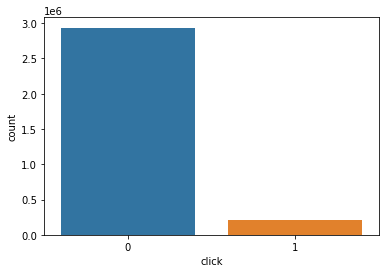

In [12]:
sns.countplot(x='click', data=df)

Only about 7% of the samples are labeled positively

Before we start modifying the dataset, let's put aside a holdout test set. This is important to preserve its natural essence - as it would arrive as unseen data. The number of samples allows us to holdout a bigger test set (here 35%), we should only verify that the rate of positive labels remains:

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.35)
print(f'Train shape: {train_df.shape}, positive labels rate: {positive_labels_rate(train_df)}')
print(f'Test shape: {test_df.shape}, positive labels rate: {positive_labels_rate(test_df)}')

Train shape: (2046738, 12), positive labels rate: 0.06761002140967726
Test shape: (1102090, 12), positive labels rate: 0.06788828498579971


As we can see the samples were divided evenly.

Let's put `test_df` in "vault" for now and fetch it in the very end, after tuning the model and playing with the data.

## 2. Clean the data

First, I am going to inspect the data from the train dataframe more thoroughly and based on that define a function that will clean the data and get rid of noise. Then this function can be reused when new data is passed. For sake of clarity, the modifications will be numbered (*) throughout the analysis and later be referred from the cleaning function.

Let's analyze the statistics:

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046738 entries, 1239809 to 1411934
Data columns (total 12 columns):
bidid            object
utc_time         int64
app_id           object
user_state       object
user_isp         object
device_maker     object
device_model     object
device_osv       object
device_height    int64
device_width     int64
marketplace      object
click            int64
dtypes: int64(4), object(8)
memory usage: 203.0+ MB


In [15]:
train_df.nunique() # distinct values per feature

bidid            1957423
utc_time         2046176
app_id             13789
user_state            51
user_isp            3167
device_maker         240
device_model        2179
device_osv            18
device_height        288
device_width         230
marketplace            1
click                  2
dtype: int64

### (0)
Denote that the feature marketplace contains only one value in the whole training set which means that it doesn't contribute to the model. I will delete this feature in the training set as well as in the new data. 

In [16]:
train_df.describe()

,utc_time,device_height,device_width,click
count,2.046738e+06,2.046738e+06,2.046738e+06,2.046738e+06
mean,1.538333e+12,1.180827e+03,1.152306e+03,6.761002e-02
std,2.319687e+09,5.190730e+02,4.528829e+02,2.510756e-01
min,1.533578e+12,1.400000e+01,1.400000e+01,0.000000e+00
25%,1.536460e+12,7.200000e+02,7.200000e+02,0.000000e+00
50%,1.538470e+12,1.080000e+03,1.080000e+03,0.000000e+00
75%,1.540095e+12,1.280000e+03,1.280000e+03,0.000000e+00
max,1.542630e+12,3.120000e+03,3.120000e+03,1.000000e+00


Only 3 features are numerical

In [17]:
train_df.isnull().sum() # count missing entries

bidid                 0
utc_time              0
app_id                0
user_state            0
user_isp             26
device_maker     626766
device_model     626680
device_osv            0
device_height         0
device_width          0
marketplace           0
click                 0
dtype: int64

device_maker and device_model both contain a significant number of missing values. Let's explore these features in order to define the optimal way to handle missing values.

In [18]:
train_df[['device_model', 'device_maker']].describe()

,device_model,device_maker
count,1420058,1419972
unique,2179,240
top,LM-X210(G),Samsung
freq,71591,561170


These are categorical variables. Note that device_model predefines device_maker. It suggests that device_maker feature is redundant, however, we will retain it for now. We will inspect the correlation of these variables during analysis of the features importance. 

### (1) 
Due to the fact, that missing values constitute a large part of the data I chose to replace NaN values with the most frequent element in the column and in addition to that, to create a new column with 1 if the corresponding category is NaN else 0. This column represents an importance column to the imputed category.

This solution is not optimal because it generates bias towards the most frequent values but at the same time we don't lose the samples and we encode the importance of these mock values by adding an additional column which mitigates the consequences.

### (2)
In contrary to aforementioned features, samples with missing user_isp will be discarded. The same missing data handling technique will be applied to missing values in other features to adapt the model to new data.

Let's collect the discussed method of data cleaning and encapsulate them into the following function:

In [19]:
def clean_data(df):
    # (0) remove the 'marketplace' feature
    df = df.drop('marketplace', axis=1)

    # (1) impute the most frequent value into 'device_model' and 'device_maker' and 
    #     append an importance column to each of the imputed features
    #     Note that at these point these are the only features that might still contain missing values
    
    columns_to_impute = ['device_model', 'device_maker']
    
    # this step of preprocessing is necessary iff there are any NaN values present
    if df[columns_to_impute].isnull().values.any():
        # (2.1) add new column and set 1 if category is null, else 0
        df[columns_to_impute[0] + '_Imputed'] = np.where(df[columns_to_impute[0]].isnull(), 
                                                         1, 0)
        df[columns_to_impute[1] + '_Imputed'] = np.where(df[columns_to_impute[1]].isnull(), 
                                                         1, 0)

        # (2.2) replace NaN with the most frequent value (mode)
        df = df.fillna({columns_to_impute[0] : df[columns_to_impute[0]].mode().iloc[0],
                        columns_to_impute[1] : df[columns_to_impute[1]].mode().iloc[0]})
        
    # (2) remove samples in which 'user_isp' or another feature, that is not 'device_model' or 'device_maker', is missing
    df = df.dropna(subset=[col for col in df if col not in columns_to_impute])
    
    return df


Clean the training data and inspect the change:

In [20]:
train_df_clean = clean_data(train_df)
train_df_clean.head()

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,click,device_model_Imputed,device_maker_Imputed
1239809,5e7e1f10-2e8f-4fed-b3f3-5223a0170575,1534118930409,com.fivestargames.slots,MD,Sprint PCS,Samsung,LM-X210(G),7.1.1,720,1280,0,1,1
912553,d5264be3-1354-4974-9f1c-88da89cfa600,1538345226338,com.luckyjackpotcasino.kenocasino,NC,CenturyLink,LG,L84VL,7.0,720,1280,0,0,0
2408779,fdfbb3ae-d15b-4064-8130-ab958509fc91,1535660762213,in.playsimple.wordtrip,CO,Verizon Wireless,Samsung,LM-X210(G),8.0.0,2560,1440,0,1,1
40988,d8a271d8-cacd-4b7c-a62f-cec8aafb17ac,1535729271331,com.ketchapp.knifehit,MO,Sprint PCS,Samsung,LM-X210(G),7.0,1920,1080,0,1,1
2180645,36b3017d-34c7-4738-a96a-8b3a121821bd,1538798809749,com.GS.Superhero.Tricky.bikerace.kidsgames,AZ,Cox Communications,Samsung,SM-J320A,7.1.1,720,1280,0,0,0


In [21]:
train_df_clean.shape

(2046712, 13)

In [22]:
train_df_clean.nunique().sort_values()

click                         2
device_model_Imputed          2
device_maker_Imputed          2
device_osv                   18
user_state                   51
device_width                230
device_maker                240
device_height               288
device_model               2179
user_isp                   3167
app_id                    13789
bidid                   1957401
utc_time                2046150
dtype: int64

## 3. Rank existing features importance

First of all, let's explore the categorical features of the data. This is essential for choosing an appropriate classifier model and ranking existing features importance.

In [23]:
cat_train_df = train_df_clean.select_dtypes(include=['object']).copy()
cat_train_df.head()

,bidid,app_id,user_state,user_isp,device_maker,device_model,device_osv
1239809,5e7e1f10-2e8f-4fed-b3f3-5223a0170575,com.fivestargames.slots,MD,Sprint PCS,Samsung,LM-X210(G),7.1.1
912553,d5264be3-1354-4974-9f1c-88da89cfa600,com.luckyjackpotcasino.kenocasino,NC,CenturyLink,LG,L84VL,7.0
2408779,fdfbb3ae-d15b-4064-8130-ab958509fc91,in.playsimple.wordtrip,CO,Verizon Wireless,Samsung,LM-X210(G),8.0.0
40988,d8a271d8-cacd-4b7c-a62f-cec8aafb17ac,com.ketchapp.knifehit,MO,Sprint PCS,Samsung,LM-X210(G),7.0
2180645,36b3017d-34c7-4738-a96a-8b3a121821bd,com.GS.Superhero.Tricky.bikerace.kidsgames,AZ,Cox Communications,Samsung,SM-J320A,7.1.1


For speeding things up change the type of the categorical features:

In [24]:
cat_train_df = cat_train_df.astype('category')
cat_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046712 entries, 1239809 to 1411934
Data columns (total 7 columns):
bidid           category
app_id          category
user_state      category
user_isp        category
device_maker    category
device_model    category
device_osv      category
dtypes: category(7)
memory usage: 138.9 MB


Let's take a look at the distribution of categories among the categorical features:

In [25]:
cat_train_df.nunique() / cat_train_df.shape[0] # rate of covering by distinct values

bidid           0.956364
app_id          0.006737
user_state      0.000025
user_isp        0.001547
device_maker    0.000117
device_model    0.001065
device_osv      0.000009
dtype: float64

In [26]:
cat_train_df.nunique()

bidid           1957401
app_id            13789
user_state           51
user_isp           3167
device_maker        240
device_model       2179
device_osv           18
dtype: int64

Most of the categorical variables have many categories. Now that we have explored the categorical data, let's derive some implications:

Classical dimension reduction techniques (e.g. PCA) are not appropriate here due to preponderance of the categorical features, many of which contain multiple categories. Although we will encode them numerically (BinaryEncoder), PCA is not a good choice, because it heavily relies on linear distances between vectors. Therefore, to rank existing features importance, let's observe the correlation between the features and their correlation to the target variable using Pearson correlation. Categorical features will be factorized before computing the correlation matrix.

In [27]:
num_train_df = train_df_clean.select_dtypes(include=['int32', 'int64']).copy()
num_train_df.head()

,utc_time,device_height,device_width,click,device_model_Imputed,device_maker_Imputed
1239809,1534118930409,720,1280,0,1,1
912553,1538345226338,720,1280,0,0,0
2408779,1535660762213,2560,1440,0,1,1
40988,1535729271331,1920,1080,0,1,1
2180645,1538798809749,720,1280,0,0,0


5 numerical features are contained in this dataframe, and the remaining 7 categorical ones are stored in `cat_X_train_df` (has to be factorized before computing Pearson correlation). Let's concatenate them along with the target variable and plot a heatmap of Pearson correlation:

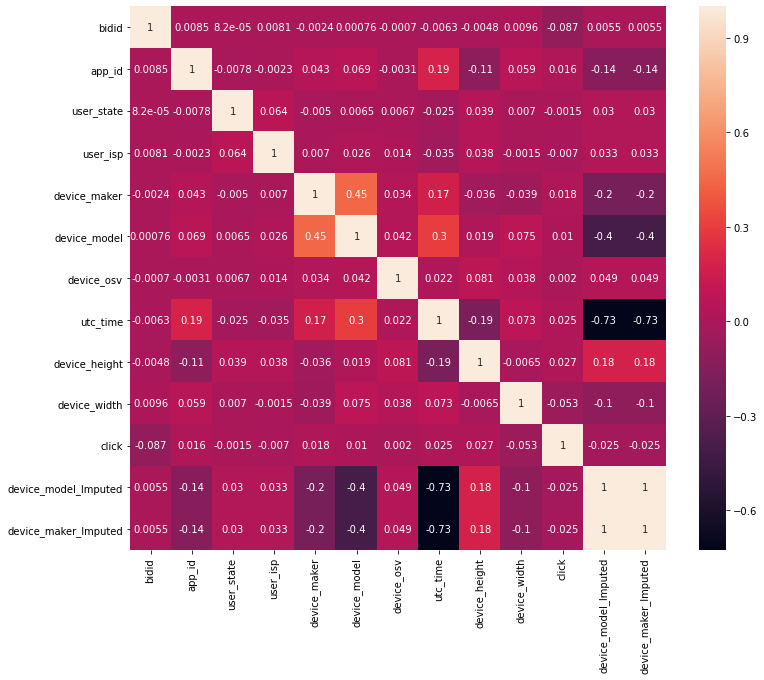

In [28]:
import seaborn as sns

plt.figure(figsize=(12, 10))

# factorize categorical features
cat_factorized_train_df = cat_train_df.apply(lambda x : pd.factorize(x)[0])

# concatenate factorized categorical features with numerical features (and target variable)
corr_matrix = pd.concat([cat_factorized_train_df, 
                         num_train_df], axis=1).corr()

# compute the correlation matrix and plot the corresponding heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

Let's analyze the correlation matrix and number the changes that will be made inside the `filter_features` function later for further use on unseen data.

First we see that the correlation values for both Imputed features are identical. It is not surprising because as I've already noticed that `device_model` defines `device_maker` and therefore it's very likely that this features were missing simultaneously. This can also be affirmed by the high correlation (~0.45) between the features themselves.

## (0)
To avoid linear dependence let's remove `device_maker` (and consequently `device_maker_Imputed`) or `device_model` (and `device_model_Imputed` accordingly) depending on whose correlation with the target variable is stronger.

## (1)
Moreover, features such as `user_state`, `user_isp` seem to have low correlation with the target variable. Let threshold be 0.01. All the features whose correlation to the targer variable is lower than the threshold will be discarded.

Relatively high correlation (~0.3) between `utc_time` and `device_model` and certain pairs of other variables are ignored in case they correlate well to the target variable. It's also worth saying that the features present in the dataframe so far don't seem particularly useful for predicting the target variable. It should be canceled out by the big number of samples and additional features that will be introduced soon.

In [29]:
X_df = train_df_clean.drop(['click'], axis=1).copy()

# select categorical features
cat_X_df = X_df.select_dtypes(include=['object']).astype('category')

# factorize categorical features
cat_factorized_X_df = cat_X_df.apply(lambda x : pd.factorize(x)[0])

# select numerical features
num_X_df = X_df.select_dtypes(include=['int32', 'int64'])

# concatenate factorized categorical features with numerical features and target variable and compute correlation matrix
corr_matrix = pd.concat([cat_factorized_X_df, 
                         num_X_df, 
                         df['click']], axis=1).corr()

# correlation with target variable
corr_click = abs(corr_matrix['click'])

columns_to_keep = set(['utc_time']) # utc_time will be used for feature engineering

# (0) remove device_maker and device_maker_Imputed features or device_model and device_model_Imputed
# based on whose correlation with the target variable is higher
if corr_click['device_maker'] > corr_click['device_model']:
    corr_click = corr_click.drop(['device_model', 'device_model_Imputed'])
else:
    corr_click = corr_click.drop(['device_maker', 'device_maker_Imputed'])


# (1) remove features whose correlation with the target variable is lower than the threshold

# filter highly correlated features
columns_to_keep.update(corr_click[corr_click >= 0.01].index.tolist())

Filter the training set:

In [30]:
train_df_clean_filtered = train_df_clean[columns_to_keep]
train_df_clean_filtered.head()

,device_width,click,device_height,device_maker_Imputed,utc_time,bidid,device_maker,app_id
1239809,1280,0,720,1,1534118930409,5e7e1f10-2e8f-4fed-b3f3-5223a0170575,Samsung,com.fivestargames.slots
912553,1280,0,720,0,1538345226338,d5264be3-1354-4974-9f1c-88da89cfa600,LG,com.luckyjackpotcasino.kenocasino
2408779,1440,0,2560,1,1535660762213,fdfbb3ae-d15b-4064-8130-ab958509fc91,Samsung,in.playsimple.wordtrip
40988,1080,0,1920,1,1535729271331,d8a271d8-cacd-4b7c-a62f-cec8aafb17ac,Samsung,com.ketchapp.knifehit
2180645,1280,0,720,0,1538798809749,36b3017d-34c7-4738-a96a-8b3a121821bd,Samsung,com.GS.Superhero.Tricky.bikerace.kidsgames


## 4. Engineer new features

Recall that so far we have the following features: `bidid`, `utc_time`, `app_id`, `device_model`, `device_osv`, `device_height`, `device_width` and `device_model_Imputed`.

Encode features related to time. The feature utc_time itself will be deleted once all the information will be extracted.

Let's cast utc_time to datetime object:

In [31]:
train_df_clean_filtered['utc_time'] = pd.to_datetime(train_df_clean_filtered['utc_time'], unit='ms')
train_df_clean_filtered.head()

C:\Users\danii\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,device_width,click,device_height,device_maker_Imputed,utc_time,bidid,device_maker,app_id
1239809,1280,0,720,1,2018-08-13 00:08:50.409,5e7e1f10-2e8f-4fed-b3f3-5223a0170575,Samsung,com.fivestargames.slots
912553,1280,0,720,0,2018-09-30 22:07:06.338,d5264be3-1354-4974-9f1c-88da89cfa600,LG,com.luckyjackpotcasino.kenocasino
2408779,1440,0,2560,1,2018-08-30 20:26:02.213,fdfbb3ae-d15b-4064-8130-ab958509fc91,Samsung,in.playsimple.wordtrip
40988,1080,0,1920,1,2018-08-31 15:27:51.331,d8a271d8-cacd-4b7c-a62f-cec8aafb17ac,Samsung,com.ketchapp.knifehit
2180645,1280,0,720,0,2018-10-06 04:06:49.749,36b3017d-34c7-4738-a96a-8b3a121821bd,Samsung,com.GS.Superhero.Tricky.bikerace.kidsgames


First let's add a day of week

In [32]:
train_df_clean_filtered['day_of_week'] = train_df_clean_filtered['utc_time'].dt.weekday
train_df_clean_filtered['day_of_week'].head()

C:\Users\danii\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1239809    0
912553     6
2408779    3
40988      4
2180645    5
Name: day_of_week, dtype: int64

Next I'll add a month

In [33]:
train_df_clean_filtered['month'] = train_df_clean_filtered['utc_time'].dt.month
train_df_clean_filtered['month'].head()

C:\Users\danii\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1239809     8
912553      9
2408779     8
40988       8
2180645    10
Name: month, dtype: int64

And finally let's add an hour of the day, which also can influence the target variable.

In [34]:
train_df_clean_filtered['hour'] = train_df_clean_filtered['utc_time'].dt.hour
train_df_clean_filtered['hour'].head()

C:\Users\danii\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1239809     0
912553     22
2408779    20
40988      15
2180645     4
Name: hour, dtype: int64

Finally remove the `utc_time` column.

In [35]:
train_df_clean_filtered.drop(['utc_time'], axis=1, inplace=True)

C:\Users\danii\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
train_df_clean_filtered.head()

,device_width,click,device_height,device_maker_Imputed,bidid,device_maker,app_id,day_of_week,month,hour
1239809,1280,0,720,1,5e7e1f10-2e8f-4fed-b3f3-5223a0170575,Samsung,com.fivestargames.slots,0,8,0
912553,1280,0,720,0,d5264be3-1354-4974-9f1c-88da89cfa600,LG,com.luckyjackpotcasino.kenocasino,6,9,22
2408779,1440,0,2560,1,fdfbb3ae-d15b-4064-8130-ab958509fc91,Samsung,in.playsimple.wordtrip,3,8,20
40988,1080,0,1920,1,d8a271d8-cacd-4b7c-a62f-cec8aafb17ac,Samsung,com.ketchapp.knifehit,4,8,15
2180645,1280,0,720,0,36b3017d-34c7-4738-a96a-8b3a121821bd,Samsung,com.GS.Superhero.Tricky.bikerace.kidsgames,5,10,4


Let's define a function that will generate these features:

In [37]:
def add_features(df):
    df['utc_time'] = pd.to_datetime(df['utc_time'], unit='ms')
    df['day_of_week'] = df['utc_time'].dt.weekday
    df['month'] = df['utc_time'].dt.month
    df['hour'] = df['utc_time'].dt.hour
    df.drop(['utc_time'], axis=1, inplace=True)
    return df

# 5. Building the model

Import the necessary modules

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

For encoding the categorical variables, Label encoder will be used. It's the most suitable encoder for categorical features with multiple classes.

In [67]:
def encode_data(df):
    cat_cols = df.select_dtypes(include=['object'])
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].apply(lambda x: str(x)))
        
    return df

In [68]:
train_df_clean_filtered = encode_data(train_df_clean_filtered)

Create training and test sets

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train_df_clean_filtered.drop(['click'], axis=1),
                                                    train_df_clean_filtered['click'], 
                                                    test_size = 0.25, random_state=42)

Create pipeline with StandardScaler and LogisticRegression

In [70]:
logreg = make_pipeline(StandardScaler(), KNeighborsClassifier())

Fit the pipeline

In [ ]:
logreg.fit(X_train, y_train)

Predict the labels of the test set: y_pred

In [ ]:
y_pred = logreg.predict(X_test)

Compute and print metrics

In [ ]:
print("Accuracy: {}".format(logreg.score(X_test, y_test)))

Compute and print the confusion matrix and classification report

In [46]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[477079      0]
 [ 34599      0]]


C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.93      1.00      0.97    477079
           1       0.00      0.00      0.00     34599

    accuracy                           0.93    511678
   macro avg       0.47      0.50      0.48    511678
weighted avg       0.87      0.93      0.90    511678



In [62]:
accuracies = []
f1_scores = []
y_pred_proba = logreg.predict_proba(X_test)
thresholds = np.arange(0, 1, 0.01)
for t in thresholds:
    y_pred = np.where(y_pred_proba[:, 1] > t, 1, 0)
    accuracies.append(logreg.score(X_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
print(np.argmax(accuracies))

C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

16


C:\Users\danii\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
plt.scatter(thresholds, accuracies, label='accuracy')
plt.scatter(thresholds, f1_scores, label='f1 score')
plt.legend()
plt.show()

0.0


# 6. Evaluation

Evaluate the model on the holdout test set. First the testset had to be preprocessed using the parameters that were set on the base of the training set, then the most relevant features are filtered, after that new features are generated and finally the categorical features are encoded:

In [ ]:
test_df_preprocessed = encode_data(add_features(clean_data(test_df)[columns_to_keep]))

In [ ]:
list(test_df_preprocessed)

In [ ]:
test_df_preprocessed.shape

In [ ]:
X_test, y_test = test_df_preprocessed.drop(['click'], axis=1), test_df_preprocessed['click']

Make predictions:

In [ ]:
y_pred = logreg.predict(X_test)

Compute and print metrics

In [ ]:
print("Accuracy: {}".format(logreg.score(X_test, y_test)))

Compute and print the confusion matrix and classification report

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

P.S.: 

For working with data and building a model the highly declarative spirit of jupyter notebook is not the most convenient tool. Object-Oriented programming could make the process easier. However, the benefits of jupyter 

      times series model
      
      if more features or another categorical feature encoding we could use deep learning
      
      app_id - extract keywords such as ad, com, free etc.